# Sample Workflow for d3rlpy Experiments

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import subprocess
import os
import d3rlpy
plt.style.use('matplotlibrc')

from Python.data_sampler import *

## Building an MDPDataset

We first read in a large batch of samples from the file. As `d3rlpy` wants it in the form (observations, actions, rewards, terminal flags), we go ahead and do that. Here's a helper function to get a dataset from a list of chunks of your choosing.

In [57]:
def get_dataset(chunks : list, batch_size=30000, 
                path="collected_data/rl_det_small.txt") -> d3rlpy.dataset.MDPDataset :
    random.seed(0)
    samples = DataSampler(path_to_data=path)
    states = []
    actions = []
    rewards = []
    next_states = []
    for chunk in chunks:
        samples.use_chunk(chunk)
        samples.read_chunk()
        [statesChunk, actionsChunk, rewardsChunk, nextStatesChunk] = samples.get_batch(batch_size)
        states.append(statesChunk)
        actions.append(actionsChunk)
        rewards.append(rewardsChunk)
        next_states.append(nextStatesChunk)
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    terminals = np.zeros(len(states))
    terminals[::100] = 1 #episode length 100, change if necessary
    print(states.shape)
    dataset = d3rlpy.dataset.MDPDataset(states.numpy(), 
                                        actions.numpy(), 
                                        rewards.numpy(), terminals)
    return dataset, states.numpy(), actions.numpy(), rewards.numpy()

We can build the dataset from there, just like this, and split into train and test sets.

In [58]:
dataset, states, actions, rewards = get_dataset([3,5,7,9], path="collected_data/rl_det_small.txt")

[ 0.00000000e+00  7.95731469e+08 -8.17891077e-02 -1.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.09713430e-01 -2.63658359e-01  6.00000000e-01]
Read chunk # 4 out of 10000
[ 0.00000000e+00  7.95731469e+08  1.24610892e-01  2.40000469e-03
 -7.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.20016566e-01  3.79282423e-01 -6.00000000e-01]
Read chunk # 6 out of 10000
[ 0.00000000e+00  7.95731469e+08 -9.01891077e-02  1.08000047e-02
  3.99986580e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.17973088e-02 -2.40776052e-01  6.00000000e-01]
Read chunk # 8 out of 10000
[ 0.00000000e+00  7.95731469e+08  6.91108923e-02 -5.99999531e-03
 -6.00001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.42355434e-01  2.22081792e-01 -6.00000000e-01]
Read chunk # 10 out of 10000
torch.Size([111080, 6])


In [59]:
print("The behavior policy value statistics are:")
dataset.compute_stats()['return']

The behavior policy value statistics are:


{'mean': -4.1227446,
 'std': 2.4676569,
 'min': -12.578855,
 'max': 0.0,
 'histogram': (array([ 26,   9,   7,   7,   8,   7,  10,  13,  27,  54,  56,  73, 109,
          84, 186, 148, 124,  83,  67,  13]),
  array([-12.578855 , -11.949912 , -11.320969 , -10.692026 , -10.063084 ,
          -9.434141 ,  -8.805199 ,  -8.176255 ,  -7.5473127,  -6.9183702,
          -6.2894273,  -5.6604843,  -5.031542 ,  -4.4025993,  -3.7736564,
          -3.1447136,  -2.515771 ,  -1.8868282,  -1.2578855,  -0.6289427,
           0.       ], dtype=float32))}

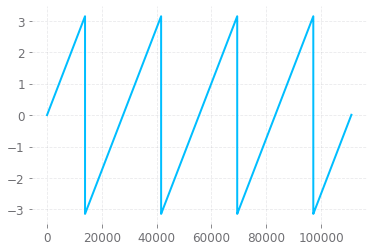

In [60]:
plt.plot(states[:,3])

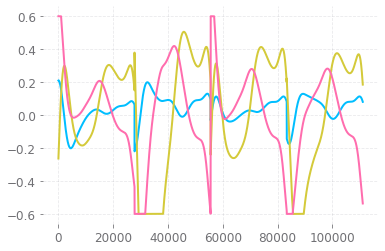

In [40]:
plt.plot(actions)

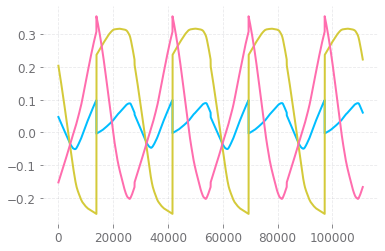

In [46]:
plt.plot(model.predict(np.array(states)))

In [34]:
from sklearn.model_selection import train_test_split
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

## Setting up an Algorithm

In [71]:
from d3rlpy.algos import CQL
from d3rlpy.models.encoders import VectorEncoderFactory

from d3rlpy.preprocessing import MinMaxActionScaler
action_scaler = MinMaxActionScaler(minimum=-0.6, maximum=0.6)
#cql = CQL(action_scaler=action_scaler)

actor_encoder = VectorEncoderFactory(hidden_units=[12, 24, 36, 24, 12],
                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)
critic_encoder = VectorEncoderFactory(hidden_units=[12, 24, 24, 12],
                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)

model = CQL(q_func_factory='mean', #qr -> quantile regression q function, but you don't have to use this
            reward_scaler='standard',
            actor_encoder_factory = actor_encoder,
            critic_encoder_factory = critic_encoder,
            action_scaler=action_scaler,
          actor_learning_rate=1e-5, 
          critic_learning_rate=0.0003, 
            use_gpu=False) #change it to true if you have one
model.build_with_dataset(dataset)

In [72]:
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer

# calculate metrics with test dataset
ave_error_init = average_value_estimation_scorer(model, test_episodes)
print(ave_error_init)

-0.11905541528132253


In [8]:
%load_ext tensorboard
%tensorboard --logdir runs

In [73]:
model.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=5, 
        tensorboard_dir='runs',
        scorers={
            'td_error': td_error_scorer,
            'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer
        })

2022-04-11 20:22.10 [debug    ] RoundIterator is selected.
2022-04-11 20:22.10 [info     ] Directory is created at d3rlpy_logs/CQL_20220411202210
2022-04-11 20:22.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-11 20:22.10 [debug    ] Fitting reward scaler...       reward_scaler=standard
2022-04-11 20:22.10 [warning  ] Skip building models since they're already built.
2022-04-11 20:22.10 [info     ] Parameters are saved to d3rlpy_logs/CQL_20220411202210/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [12, 24, 36, 24, 12], 'activation': 'relu', 'use_batch_norm': True, 'dropout_rate': 0.2, 'use_dense': False}}, 'actor_learning_rate': 1e-05, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls

Epoch 1/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:22.46 [info     ] CQL_20220411202210: epoch=1 step=343 epoch=1 metrics={'time_sample_batch': 0.0003640561340154086, 'time_algorithm_update': 0.09910516697185727, 'temp_loss': 3.1179318740833604, 'temp': 0.9831104662606042, 'alpha_loss': -16.99623551104576, 'alpha': 1.0174694829362474, 'critic_loss': 19.963924430202116, 'actor_loss': 0.10319940020050582, 'time_step': 0.09955320413884199, 'td_error': 0.6941765645801038, 'init_value': -0.17975027859210968, 'ave_value': -0.18088335357226745} step=343
2022-04-11 20:22.46 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411202210/model_343.pt


Epoch 2/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:23.21 [info     ] CQL_20220411202210: epoch=2 step=686 epoch=2 metrics={'time_sample_batch': 0.0003437544097010665, 'time_algorithm_update': 0.09765913604647355, 'temp_loss': 3.128235389470359, 'temp': 0.9499906450944461, 'alpha_loss': -17.784102353688233, 'alpha': 1.0536712428918733, 'critic_loss': 19.684812562458717, 'actor_loss': 0.09181729169513585, 'time_step': 0.09808662125390055, 'td_error': 0.6556398745737388, 'init_value': -0.2532026469707489, 'ave_value': -0.2550200841122522} step=686
2022-04-11 20:23.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411202210/model_686.pt


Epoch 3/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:23.57 [info     ] CQL_20220411202210: epoch=3 step=1029 epoch=3 metrics={'time_sample_batch': 0.0003479382039506651, 'time_algorithm_update': 0.09872052412338925, 'temp_loss': 3.123503149772177, 'temp': 0.9179787700099779, 'alpha_loss': -18.502506828864185, 'alpha': 1.0918171881934298, 'critic_loss': 20.1790456966478, 'actor_loss': 0.10693125718113024, 'time_step': 0.09914977418437991, 'td_error': 0.6527405274526444, 'init_value': -0.3330529034137726, 'ave_value': -0.33537927118980104} step=1029
2022-04-11 20:23.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411202210/model_1029.pt


Epoch 4/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:24.32 [info     ] CQL_20220411202210: epoch=4 step=1372 epoch=4 metrics={'time_sample_batch': 0.0003403317476500575, 'time_algorithm_update': 0.09723380703272694, 'temp_loss': 3.115784188401247, 'temp': 0.8871733085754662, 'alpha_loss': -19.325636877610453, 'alpha': 1.1318861127942366, 'critic_loss': 20.90614158141022, 'actor_loss': 0.15384111991939584, 'time_step': 0.09765500368946843, 'td_error': 0.6666600515027672, 'init_value': -0.5152516961097717, 'ave_value': -0.517741759853348} step=1372
2022-04-11 20:24.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411202210/model_1372.pt


Epoch 5/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:25.08 [info     ] CQL_20220411202210: epoch=5 step=1715 epoch=5 metrics={'time_sample_batch': 0.0003451348741270015, 'time_algorithm_update': 0.09774853814795136, 'temp_loss': 3.0800633882294592, 'temp': 0.857458715362382, 'alpha_loss': -20.207693150022635, 'alpha': 1.1740261302397481, 'critic_loss': 21.876747848688687, 'actor_loss': 0.26695471090527995, 'time_step': 0.09817645848666266, 'td_error': 0.6684542047784601, 'init_value': -0.7238405346870422, 'ave_value': -0.7260201782731953} step=1715
2022-04-11 20:25.08 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411202210/model_1715.pt


[(1,
  {'time_sample_batch': 0.0003640561340154086,
   'time_algorithm_update': 0.09910516697185727,
   'temp_loss': 3.1179318740833604,
   'temp': 0.9831104662606042,
   'alpha_loss': -16.99623551104576,
   'alpha': 1.0174694829362474,
   'critic_loss': 19.963924430202116,
   'actor_loss': 0.10319940020050582,
   'time_step': 0.09955320413884199,
   'td_error': 0.6941765645801038,
   'init_value': -0.17975027859210968,
   'ave_value': -0.18088335357226745}),
 (2,
  {'time_sample_batch': 0.0003437544097010665,
   'time_algorithm_update': 0.09765913604647355,
   'temp_loss': 3.128235389470359,
   'temp': 0.9499906450944461,
   'alpha_loss': -17.784102353688233,
   'alpha': 1.0536712428918733,
   'critic_loss': 19.684812562458717,
   'actor_loss': 0.09181729169513585,
   'time_step': 0.09808662125390055,
   'td_error': 0.6556398745737388,
   'init_value': -0.2532026469707489,
   'ave_value': -0.2550200841122522}),
 (3,
  {'time_sample_batch': 0.0003479382039506651,
   'time_algorithm_upd

## Off-Policy Evaluation

We do get some metrics on a test set of initial state value and average value. However, these estimates (using the critic's Q-function) of model performance are biased. They're useful for validation during training, but not much else. Instead, we fit a Q-function to the data (or a separate dataset, as I've done here) separately and evaluate the model's performance on it.

Feel free to change the chunks and number of steps.

In [80]:
ope_train_episodes

[array([[ 1.3931090e-01,  1.8200004e-02, -1.0001342e-04,  0.0000000e+00,
         -5.3342347e+00, -1.5709162e+00],
        [ 1.3932748e-01,  1.8200640e-02, -9.7032906e-05,  2.2659905e-04,
         -5.3342495e+00, -1.5709161e+00],
        [ 1.3934240e-01,  1.8200792e-02, -9.4021627e-05,  4.5319795e-04,
         -5.3342643e+00, -1.5709161e+00],
        ...,
        [ 9.6320137e-02, -1.0185774e-02,  2.7590317e-03,  8.7887626e-03,
         -5.7407694e+00, -1.5684357e+00],
        [ 9.6328326e-02, -1.0186378e-02,  2.7575274e-03,  9.0153618e-03,
         -5.7407842e+00, -1.5684357e+00],
        [ 9.6336506e-02, -1.0186981e-02,  2.7560228e-03,  9.2419609e-03,
         -5.7407985e+00, -1.5684355e+00]], dtype=float32),
 array([[-0.07502301,  0.36985156, -0.6       ],
        [-0.07489344,  0.36923492, -0.6       ],
        [-0.07476014,  0.36861947, -0.6       ],
        ...,
        [ 0.11609613,  0.28617814, -0.6       ],
        [ 0.11601332,  0.28579786, -0.6       ],
        [ 0.11593043, 

In [81]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope = get_dataset([2,4,6,8], path="collected_data/rl_det_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes,
        eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08  7.01089229e-03 -4.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.21623335e-01 -2.86362315e-02 -8.00043364e-02]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01 -1.37999953e-02
  7.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.76352555e-01 -3.26280816e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-11 20:30.22 [debug    ] RoundIterator is selected.
2022-04-11 20:30.22 [info     ] Directory is created at d3rlpy_logs/FQE_2022041120302

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-04-11 20:30.25 [info     ] FQE_20220411203022: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.0001349248212670954, 'time_algorithm_update': 0.0023120750327316666, 'loss': 0.0005652808520956285, 'time_step': 0.0025094524874502543, 'init_value': -0.2804785370826721, 'ave_value': -0.280714014080624, 'soft_opc': nan} step=878


2022-04-11 20:30.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.28 [info     ] FQE_20220411203022: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00012890515946581586, 'time_algorithm_update': 0.0022976536957169448, 'loss': 0.001071593963752404, 'time_step': 0.0024847389625253873, 'init_value': -0.3681376576423645, 'ave_value': -0.3683402691273206, 'soft_opc': nan} step=1756


2022-04-11 20:30.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.30 [info     ] FQE_20220411203022: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00012407894829682717, 'time_algorithm_update': 0.0021984992646410686, 'loss': 0.001587349711852806, 'time_step': 0.0023737241575549567, 'init_value': -0.4168953597545624, 'ave_value': -0.417124000146736, 'soft_opc': nan} step=2634


2022-04-11 20:30.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.33 [info     ] FQE_20220411203022: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00012714227402671867, 'time_algorithm_update': 0.002262220838889989, 'loss': 0.0019553081814018196, 'time_step': 0.0024437871772227363, 'init_value': -0.4666008949279785, 'ave_value': -0.4667402123602511, 'soft_opc': nan} step=3512


2022-04-11 20:30.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.36 [info     ] FQE_20220411203022: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.0001300271931433189, 'time_algorithm_update': 0.0022649803031278364, 'loss': 0.002407608443104592, 'time_step': 0.0024513117544743357, 'init_value': -0.528203547000885, 'ave_value': -0.5281449114209354, 'soft_opc': nan} step=4390


2022-04-11 20:30.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.38 [info     ] FQE_20220411203022: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.0001278974472254447, 'time_algorithm_update': 0.0022424858632011675, 'loss': 0.0028855211050948805, 'time_step': 0.002428322555263928, 'init_value': -0.5527677536010742, 'ave_value': -0.5526422702078748, 'soft_opc': nan} step=5268


2022-04-11 20:30.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.41 [info     ] FQE_20220411203022: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.0001274607990760195, 'time_algorithm_update': 0.002252505146017922, 'loss': 0.0034168769089310217, 'time_step': 0.002435535667697498, 'init_value': -0.6051788926124573, 'ave_value': -0.6051048016901297, 'soft_opc': nan} step=6146


2022-04-11 20:30.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.44 [info     ] FQE_20220411203022: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.00012632002863091055, 'time_algorithm_update': 0.002224292461855808, 'loss': 0.0036910072756256925, 'time_step': 0.00240665171846985, 'init_value': -0.6318846344947815, 'ave_value': -0.6316813222090987, 'soft_opc': nan} step=7024


2022-04-11 20:30.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.46 [info     ] FQE_20220411203022: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.0001253449020733323, 'time_algorithm_update': 0.002193044421341533, 'loss': 0.004243583698560517, 'time_step': 0.0023739604037552055, 'init_value': -0.6504100561141968, 'ave_value': -0.6502754682512254, 'soft_opc': nan} step=7902


2022-04-11 20:30.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.49 [info     ] FQE_20220411203022: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.00012699835392771658, 'time_algorithm_update': 0.002225618970692837, 'loss': 0.004319703386982612, 'time_step': 0.0024101345848657005, 'init_value': -0.6643086671829224, 'ave_value': -0.6641993559281042, 'soft_opc': nan} step=8780


2022-04-11 20:30.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.52 [info     ] FQE_20220411203022: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.00012612913083921533, 'time_algorithm_update': 0.002249477936086459, 'loss': 0.004742925620517979, 'time_step': 0.002433968024807802, 'init_value': -0.7116799354553223, 'ave_value': -0.7115881127707903, 'soft_opc': nan} step=9658


2022-04-11 20:30.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.54 [info     ] FQE_20220411203022: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.0001280207297253446, 'time_algorithm_update': 0.0022551114575466427, 'loss': 0.005230954584883519, 'time_step': 0.002441855660875186, 'init_value': -0.7337387800216675, 'ave_value': -0.7336135277250471, 'soft_opc': nan} step=10536


2022-04-11 20:30.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:30.57 [info     ] FQE_20220411203022: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00012974478389244688, 'time_algorithm_update': 0.002262535562276297, 'loss': 0.005460582964634571, 'time_step': 0.002453421405887821, 'init_value': -0.7569722533226013, 'ave_value': -0.7568642522738281, 'soft_opc': nan} step=11414


2022-04-11 20:30.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.00 [info     ] FQE_20220411203022: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00013250424813029434, 'time_algorithm_update': 0.0022999224738814023, 'loss': 0.005603016067946458, 'time_step': 0.0024941111479913456, 'init_value': -0.7317320704460144, 'ave_value': -0.7316504966663527, 'soft_opc': nan} step=12292


2022-04-11 20:31.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.02 [info     ] FQE_20220411203022: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.00012946916332549007, 'time_algorithm_update': 0.002315142160124551, 'loss': 0.005191291318638783, 'time_step': 0.0025049100432689205, 'init_value': -0.7143442630767822, 'ave_value': -0.7142754305762733, 'soft_opc': nan} step=13170


2022-04-11 20:31.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.05 [info     ] FQE_20220411203022: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.0001277744362729014, 'time_algorithm_update': 0.002269402451830193, 'loss': 0.005239490841814091, 'time_step': 0.002456877660642724, 'init_value': -0.7302336692810059, 'ave_value': -0.7301940831411478, 'soft_opc': nan} step=14048


2022-04-11 20:31.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.08 [info     ] FQE_20220411203022: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.00012791862791926008, 'time_algorithm_update': 0.0022332388610666054, 'loss': 0.005544430901112437, 'time_step': 0.0024202163235744747, 'init_value': -0.7728478908538818, 'ave_value': -0.7727526035781636, 'soft_opc': nan} step=14926


2022-04-11 20:31.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.10 [info     ] FQE_20220411203022: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00012897793415738673, 'time_algorithm_update': 0.002225478309162114, 'loss': 0.005832644710120397, 'time_step': 0.0024138317021259142, 'init_value': -0.7834199666976929, 'ave_value': -0.7832744025787743, 'soft_opc': nan} step=15804


2022-04-11 20:31.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.13 [info     ] FQE_20220411203022: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00012562188037707213, 'time_algorithm_update': 0.0022678421407191247, 'loss': 0.006010126001568103, 'time_step': 0.0024530366232835077, 'init_value': -0.7724221348762512, 'ave_value': -0.7723226073525082, 'soft_opc': nan} step=16682


2022-04-11 20:31.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.16 [info     ] FQE_20220411203022: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012476867858261074, 'time_algorithm_update': 0.0021977802072407717, 'loss': 0.006363401449272408, 'time_step': 0.002379963501167732, 'init_value': -0.8137438297271729, 'ave_value': -0.8136883846237299, 'soft_opc': nan} step=17560


2022-04-11 20:31.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.18 [info     ] FQE_20220411203022: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00012590130260702146, 'time_algorithm_update': 0.0021982524280939122, 'loss': 0.006523212831358139, 'time_step': 0.002383070546022037, 'init_value': -0.8109729290008545, 'ave_value': -0.8108685677582983, 'soft_opc': nan} step=18438


2022-04-11 20:31.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.21 [info     ] FQE_20220411203022: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.00012889864232925729, 'time_algorithm_update': 0.0022363632849517335, 'loss': 0.006789995032390223, 'time_step': 0.002425590245761741, 'init_value': -0.839612603187561, 'ave_value': -0.8394741547892274, 'soft_opc': nan} step=19316


2022-04-11 20:31.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.24 [info     ] FQE_20220411203022: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00013542229602440072, 'time_algorithm_update': 0.0024021755318435287, 'loss': 0.006772179896487757, 'time_step': 0.0025999114290728383, 'init_value': -0.7998709678649902, 'ave_value': -0.7997480875076297, 'soft_opc': nan} step=20194


2022-04-11 20:31.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.27 [info     ] FQE_20220411203022: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00013628880363933588, 'time_algorithm_update': 0.0024052681846879337, 'loss': 0.006437828107746597, 'time_step': 0.0026053852806873366, 'init_value': -0.786359965801239, 'ave_value': -0.7862249521121235, 'soft_opc': nan} step=21072


2022-04-11 20:31.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.29 [info     ] FQE_20220411203022: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00013050104328059934, 'time_algorithm_update': 0.002291892275451799, 'loss': 0.006238675982978348, 'time_step': 0.002484352279089578, 'init_value': -0.7787888050079346, 'ave_value': -0.7786501809139963, 'soft_opc': nan} step=21950


2022-04-11 20:31.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.32 [info     ] FQE_20220411203022: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.000128959740484494, 'time_algorithm_update': 0.002236702719147493, 'loss': 0.005774211353597379, 'time_step': 0.0024251280721607946, 'init_value': -0.7214229106903076, 'ave_value': -0.7213111549457919, 'soft_opc': nan} step=22828


2022-04-11 20:31.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.35 [info     ] FQE_20220411203022: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.0001277673760416296, 'time_algorithm_update': 0.002273910409497237, 'loss': 0.005485544896532805, 'time_step': 0.0024597617651172543, 'init_value': -0.7393091917037964, 'ave_value': -0.7392657204356191, 'soft_opc': nan} step=23706


2022-04-11 20:31.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.37 [info     ] FQE_20220411203022: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.0001281377666360425, 'time_algorithm_update': 0.00222778401776707, 'loss': 0.005830501587553337, 'time_step': 0.002416255262283638, 'init_value': -0.8016424775123596, 'ave_value': -0.8016558415530012, 'soft_opc': nan} step=24584


2022-04-11 20:31.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.40 [info     ] FQE_20220411203022: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012865397816095374, 'time_algorithm_update': 0.0022718719034911833, 'loss': 0.006783177366567621, 'time_step': 0.00246123979737927, 'init_value': -0.8335576057434082, 'ave_value': -0.8335678044904179, 'soft_opc': nan} step=25462


2022-04-11 20:31.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.43 [info     ] FQE_20220411203022: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.00012761476642721606, 'time_algorithm_update': 0.0022061615164024684, 'loss': 0.007237932071875818, 'time_step': 0.002393801011365747, 'init_value': -0.8371175527572632, 'ave_value': -0.8370677656457169, 'soft_opc': nan} step=26340


2022-04-11 20:31.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.45 [info     ] FQE_20220411203022: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00012979339086927966, 'time_algorithm_update': 0.00229170572241781, 'loss': 0.007389177171103153, 'time_step': 0.002482135094922876, 'init_value': -0.89298415184021, 'ave_value': -0.8929411121218642, 'soft_opc': nan} step=27218


2022-04-11 20:31.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.48 [info     ] FQE_20220411203022: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.0001267593922539018, 'time_algorithm_update': 0.0022596696514746595, 'loss': 0.007598786384381425, 'time_step': 0.00244662457555193, 'init_value': -0.8666218519210815, 'ave_value': -0.866612084475517, 'soft_opc': nan} step=28096


2022-04-11 20:31.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.51 [info     ] FQE_20220411203022: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.00012913651781364563, 'time_algorithm_update': 0.002247211873395568, 'loss': 0.00704873712191584, 'time_step': 0.0024378886255425037, 'init_value': -0.8338059186935425, 'ave_value': -0.8338595002804587, 'soft_opc': nan} step=28974


2022-04-11 20:31.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.53 [info     ] FQE_20220411203022: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.000129481654503894, 'time_algorithm_update': 0.0022574421485084067, 'loss': 0.0073396478415393455, 'time_step': 0.0024481675076321752, 'init_value': -0.882264256477356, 'ave_value': -0.8823659551199263, 'soft_opc': nan} step=29852


2022-04-11 20:31.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.56 [info     ] FQE_20220411203022: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.000132795889991291, 'time_algorithm_update': 0.002317933666950478, 'loss': 0.007453468177846297, 'time_step': 0.002513430656224557, 'init_value': -0.8611637949943542, 'ave_value': -0.8612648454455247, 'soft_opc': nan} step=30730


2022-04-11 20:31.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:31.59 [info     ] FQE_20220411203022: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.00013029005098451514, 'time_algorithm_update': 0.002270566032253257, 'loss': 0.006958409778245723, 'time_step': 0.0024616158904681718, 'init_value': -0.803619921207428, 'ave_value': -0.8036812238353704, 'soft_opc': nan} step=31608


2022-04-11 20:31.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.01 [info     ] FQE_20220411203022: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00012527538595004072, 'time_algorithm_update': 0.0021784031309679593, 'loss': 0.006157271422019973, 'time_step': 0.002361672071226637, 'init_value': -0.7953843474388123, 'ave_value': -0.7953867694225389, 'soft_opc': nan} step=32486


2022-04-11 20:32.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.04 [info     ] FQE_20220411203022: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.0001252922218861504, 'time_algorithm_update': 0.0022143847850026196, 'loss': 0.005902853368152634, 'time_step': 0.0023986446015655588, 'init_value': -0.7629879117012024, 'ave_value': -0.7630265192147069, 'soft_opc': nan} step=33364


2022-04-11 20:32.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.07 [info     ] FQE_20220411203022: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00013103734930989955, 'time_algorithm_update': 0.0022852912307600227, 'loss': 0.0056687797102306986, 'time_step': 0.002478204718483336, 'init_value': -0.7546424865722656, 'ave_value': -0.754727314767692, 'soft_opc': nan} step=34242


2022-04-11 20:32.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.09 [info     ] FQE_20220411203022: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00013412647203866877, 'time_algorithm_update': 0.002336713067491397, 'loss': 0.005581058911403179, 'time_step': 0.002535653820341975, 'init_value': -0.7600042819976807, 'ave_value': -0.7600067153666856, 'soft_opc': nan} step=35120


2022-04-11 20:32.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.12 [info     ] FQE_20220411203022: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.0001329821714779239, 'time_algorithm_update': 0.002305483220650015, 'loss': 0.005633262560836566, 'time_step': 0.002499259957419984, 'init_value': -0.7625487446784973, 'ave_value': -0.7625003435443578, 'soft_opc': nan} step=35998


2022-04-11 20:32.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.15 [info     ] FQE_20220411203022: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.0001302666979118469, 'time_algorithm_update': 0.0022791127137551277, 'loss': 0.005948476523912144, 'time_step': 0.00247135629414969, 'init_value': -0.7883729338645935, 'ave_value': -0.7884285201622253, 'soft_opc': nan} step=36876


2022-04-11 20:32.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.17 [info     ] FQE_20220411203022: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00012940290577047778, 'time_algorithm_update': 0.0022327617523610456, 'loss': 0.005862848481749132, 'time_step': 0.002422592362944792, 'init_value': -0.7594621181488037, 'ave_value': -0.7594639701234607, 'soft_opc': nan} step=37754


2022-04-11 20:32.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.20 [info     ] FQE_20220411203022: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.0001291674742122989, 'time_algorithm_update': 0.0022505242080514687, 'loss': 0.005716534204759605, 'time_step': 0.002438787175745519, 'init_value': -0.7568783760070801, 'ave_value': -0.7568601038909862, 'soft_opc': nan} step=38632


2022-04-11 20:32.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.23 [info     ] FQE_20220411203022: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00013032670987765717, 'time_algorithm_update': 0.0022649436442346944, 'loss': 0.005666031383296457, 'time_step': 0.0024564619216397576, 'init_value': -0.7555968761444092, 'ave_value': -0.755659775783733, 'soft_opc': nan} step=39510


2022-04-11 20:32.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.26 [info     ] FQE_20220411203022: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00013241300821847417, 'time_algorithm_update': 0.002412405535409011, 'loss': 0.005785477087904553, 'time_step': 0.002606045140763893, 'init_value': -0.7722025513648987, 'ave_value': -0.7722644210455722, 'soft_opc': nan} step=40388


2022-04-11 20:32.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.28 [info     ] FQE_20220411203022: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.0001342293884868231, 'time_algorithm_update': 0.0023203865542227153, 'loss': 0.006047777619911991, 'time_step': 0.002517558447592351, 'init_value': -0.7867128252983093, 'ave_value': -0.7868192966889227, 'soft_opc': nan} step=41266


2022-04-11 20:32.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.31 [info     ] FQE_20220411203022: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00013512468012155868, 'time_algorithm_update': 0.002359348440496145, 'loss': 0.006272837466982529, 'time_step': 0.002559535867260909, 'init_value': -0.8135640621185303, 'ave_value': -0.8136331861788161, 'soft_opc': nan} step=42144


2022-04-11 20:32.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.34 [info     ] FQE_20220411203022: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00013522216562258084, 'time_algorithm_update': 0.002369853249986514, 'loss': 0.006389806867037776, 'time_step': 0.0025706972782595554, 'init_value': -0.7944595813751221, 'ave_value': -0.7945686410522798, 'soft_opc': nan} step=43022


2022-04-11 20:32.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:32.37 [info     ] FQE_20220411203022: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00013297646898343513, 'time_algorithm_update': 0.0023501907774419067, 'loss': 0.006060594008408201, 'time_step': 0.002545715736093717, 'init_value': -0.7672800421714783, 'ave_value': -0.767405741072308, 'soft_opc': nan} step=43900


2022-04-11 20:32.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203022/model_43900.pt


[(1,
  {'time_sample_batch': 0.0001349248212670954,
   'time_algorithm_update': 0.0023120750327316666,
   'loss': 0.0005652808520956285,
   'time_step': 0.0025094524874502543,
   'init_value': -0.2804785370826721,
   'ave_value': -0.280714014080624,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00012890515946581586,
   'time_algorithm_update': 0.0022976536957169448,
   'loss': 0.001071593963752404,
   'time_step': 0.0024847389625253873,
   'init_value': -0.3681376576423645,
   'ave_value': -0.3683402691273206,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00012407894829682717,
   'time_algorithm_update': 0.0021984992646410686,
   'loss': 0.001587349711852806,
   'time_step': 0.0023737241575549567,
   'init_value': -0.4168953597545624,
   'ave_value': -0.417124000146736,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00012714227402671867,
   'time_algorithm_update': 0.002262220838889989,
   'loss': 0.0019553081814018196,
   'time_step': 0.0024437871772227363,
   'ini

In [82]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope = get_dataset([2,4,6,8], path="collected_data/rl_stoch_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08  1.39310892e-01  1.82000047e-02
 -1.00013420e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -7.50230117e-02  3.69851546e-01 -6.00000000e-01]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.15389108e-01  1.64000047e-02
 -8.80001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.08831172e-01 -2.48178665e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.28589108e-01  1.20000047e-02
  1.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  7.75212759e-03 -3.52719043e-01  6.00000000e-01]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01  7.00000469e-03
 -8.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.65974295e-01 -2.19295880e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-11 20:32.37 [debug    ] RoundIterator is selected.
2022-04-11 20:32.37 [info     ] Directory is created at d3rlpy_logs/FQE_2022041120323

Epoch 1/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.40 [info     ] FQE_20220411203237: epoch=1 step=879 epoch=1 metrics={'time_sample_batch': 0.00014019473556501196, 'time_algorithm_update': 0.002362467187527775, 'loss': 0.0005614129783283968, 'time_step': 0.0025678274981397816, 'init_value': -0.23880623281002045, 'ave_value': -0.23976656565145546, 'soft_opc': nan} step=879


2022-04-11 20:32.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_879.pt


Epoch 2/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.43 [info     ] FQE_20220411203237: epoch=2 step=1758 epoch=2 metrics={'time_sample_batch': 0.00013613646619013416, 'time_algorithm_update': 0.0024210595704860925, 'loss': 0.0012474334368383266, 'time_step': 0.002627215423410392, 'init_value': -0.3639397919178009, 'ave_value': -0.365467881871475, 'soft_opc': nan} step=1758


2022-04-11 20:32.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_1758.pt


Epoch 3/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.46 [info     ] FQE_20220411203237: epoch=3 step=2637 epoch=3 metrics={'time_sample_batch': 0.00013266271562977728, 'time_algorithm_update': 0.0023152410509372054, 'loss': 0.0018603408706345792, 'time_step': 0.0025077414051528947, 'init_value': -0.4343857765197754, 'ave_value': -0.43619836628639086, 'soft_opc': nan} step=2637


2022-04-11 20:32.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_2637.pt


Epoch 4/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.49 [info     ] FQE_20220411203237: epoch=4 step=3516 epoch=4 metrics={'time_sample_batch': 0.00013175054079300985, 'time_algorithm_update': 0.002289967325360295, 'loss': 0.002795664760577788, 'time_step': 0.0024794433710925, 'init_value': -0.5042094588279724, 'ave_value': -0.5061086104796814, 'soft_opc': nan} step=3516


2022-04-11 20:32.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_3516.pt


Epoch 5/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.51 [info     ] FQE_20220411203237: epoch=5 step=4395 epoch=5 metrics={'time_sample_batch': 0.0001372455601263643, 'time_algorithm_update': 0.002537380984483183, 'loss': 0.0033886088520663424, 'time_step': 0.002737941459855393, 'init_value': -0.5234676003456116, 'ave_value': -0.525539960622359, 'soft_opc': nan} step=4395


2022-04-11 20:32.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_4395.pt


Epoch 6/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.54 [info     ] FQE_20220411203237: epoch=6 step=5274 epoch=6 metrics={'time_sample_batch': 0.0001380782621034312, 'time_algorithm_update': 0.0023392532465807813, 'loss': 0.0036760593774621845, 'time_step': 0.002539149187801912, 'init_value': -0.5723488926887512, 'ave_value': -0.5742152086039162, 'soft_opc': nan} step=5274


2022-04-11 20:32.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_5274.pt


Epoch 7/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:32.57 [info     ] FQE_20220411203237: epoch=7 step=6153 epoch=7 metrics={'time_sample_batch': 0.00013235784363556776, 'time_algorithm_update': 0.002300147988554832, 'loss': 0.004101945523965266, 'time_step': 0.0024958701128303257, 'init_value': -0.6181296706199646, 'ave_value': -0.6199462448027019, 'soft_opc': nan} step=6153


2022-04-11 20:32.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_6153.pt


Epoch 8/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.00 [info     ] FQE_20220411203237: epoch=8 step=7032 epoch=8 metrics={'time_sample_batch': 0.00013466825257389212, 'time_algorithm_update': 0.00252056637179187, 'loss': 0.004381364277713175, 'time_step': 0.002716329995547003, 'init_value': -0.6549180150032043, 'ave_value': -0.6568164990994351, 'soft_opc': nan} step=7032


2022-04-11 20:33.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_7032.pt


Epoch 9/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.03 [info     ] FQE_20220411203237: epoch=9 step=7911 epoch=9 metrics={'time_sample_batch': 0.0001375273768541078, 'time_algorithm_update': 0.002410252346520538, 'loss': 0.00571533787256525, 'time_step': 0.002612958589104662, 'init_value': -0.7458425760269165, 'ave_value': -0.7478787435615494, 'soft_opc': nan} step=7911


2022-04-11 20:33.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_7911.pt


Epoch 10/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.06 [info     ] FQE_20220411203237: epoch=10 step=8790 epoch=10 metrics={'time_sample_batch': 0.00013991780112899068, 'time_algorithm_update': 0.0024028868669807163, 'loss': 0.00652466572476062, 'time_step': 0.002606861420458901, 'init_value': -0.8092364072799683, 'ave_value': -0.8113366154275325, 'soft_opc': nan} step=8790


2022-04-11 20:33.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_8790.pt


Epoch 11/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.08 [info     ] FQE_20220411203237: epoch=11 step=9669 epoch=11 metrics={'time_sample_batch': 0.00013757131747960772, 'time_algorithm_update': 0.0023561627927222487, 'loss': 0.006592534509730827, 'time_step': 0.0025585177815408023, 'init_value': -0.795086145401001, 'ave_value': -0.7968562395031453, 'soft_opc': nan} step=9669


2022-04-11 20:33.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_9669.pt


Epoch 12/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.11 [info     ] FQE_20220411203237: epoch=12 step=10548 epoch=12 metrics={'time_sample_batch': 0.00013531461375022776, 'time_algorithm_update': 0.002345107928071006, 'loss': 0.007630475940380655, 'time_step': 0.0025461064535060706, 'init_value': -0.8673317432403564, 'ave_value': -0.8691559462792903, 'soft_opc': nan} step=10548


2022-04-11 20:33.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_10548.pt


Epoch 13/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.14 [info     ] FQE_20220411203237: epoch=13 step=11427 epoch=13 metrics={'time_sample_batch': 0.00013456599568615458, 'time_algorithm_update': 0.002356424537806245, 'loss': 0.007390104269650607, 'time_step': 0.0025543542716554677, 'init_value': -0.8115273714065552, 'ave_value': -0.8133280098855913, 'soft_opc': nan} step=11427


2022-04-11 20:33.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_11427.pt


Epoch 14/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.17 [info     ] FQE_20220411203237: epoch=14 step=12306 epoch=14 metrics={'time_sample_batch': 0.00013571441919459147, 'time_algorithm_update': 0.0023247636897029593, 'loss': 0.0072015078997799565, 'time_step': 0.002525399298120006, 'init_value': -0.835570752620697, 'ave_value': -0.837522870173922, 'soft_opc': nan} step=12306


2022-04-11 20:33.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_12306.pt


Epoch 15/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.19 [info     ] FQE_20220411203237: epoch=15 step=13185 epoch=15 metrics={'time_sample_batch': 0.0001360220035730911, 'time_algorithm_update': 0.0023583213081403262, 'loss': 0.00789520441816446, 'time_step': 0.0025599615836984333, 'init_value': -0.8556253910064697, 'ave_value': -0.8576041920266015, 'soft_opc': nan} step=13185


2022-04-11 20:33.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_13185.pt


Epoch 16/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.22 [info     ] FQE_20220411203237: epoch=16 step=14064 epoch=16 metrics={'time_sample_batch': 0.00013793152211333568, 'time_algorithm_update': 0.0024236108391493794, 'loss': 0.0081997677688087, 'time_step': 0.002626163832021112, 'init_value': -0.8569891452789307, 'ave_value': -0.8594553538628885, 'soft_opc': nan} step=14064


2022-04-11 20:33.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_14064.pt


Epoch 17/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.25 [info     ] FQE_20220411203237: epoch=17 step=14943 epoch=17 metrics={'time_sample_batch': 0.00013610852863194593, 'time_algorithm_update': 0.002421324027954379, 'loss': 0.008505141782884458, 'time_step': 0.002623138709822341, 'init_value': -0.8952665328979492, 'ave_value': -0.89778190127375, 'soft_opc': nan} step=14943


2022-04-11 20:33.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_14943.pt


Epoch 18/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.28 [info     ] FQE_20220411203237: epoch=18 step=15822 epoch=18 metrics={'time_sample_batch': 0.0001362994804859704, 'time_algorithm_update': 0.0023455568276710206, 'loss': 0.008700856120878548, 'time_step': 0.0025466044472617364, 'init_value': -0.9003485441207886, 'ave_value': -0.9030753741008112, 'soft_opc': nan} step=15822


2022-04-11 20:33.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_15822.pt


Epoch 19/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.31 [info     ] FQE_20220411203237: epoch=19 step=16701 epoch=19 metrics={'time_sample_batch': 0.0001389001145433376, 'time_algorithm_update': 0.0023923733942337816, 'loss': 0.008817625961281805, 'time_step': 0.0025971169086582155, 'init_value': -0.9194061160087585, 'ave_value': -0.9219570372072968, 'soft_opc': nan} step=16701


2022-04-11 20:33.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_16701.pt


Epoch 20/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.34 [info     ] FQE_20220411203237: epoch=20 step=17580 epoch=20 metrics={'time_sample_batch': 0.00013597643551701706, 'time_algorithm_update': 0.0024046043487132205, 'loss': 0.009226635248795051, 'time_step': 0.002604941323619925, 'init_value': -0.8927803635597229, 'ave_value': -0.8951763719691843, 'soft_opc': nan} step=17580


2022-04-11 20:33.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_17580.pt


Epoch 21/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.36 [info     ] FQE_20220411203237: epoch=21 step=18459 epoch=21 metrics={'time_sample_batch': 0.0001384368393065851, 'time_algorithm_update': 0.002404053734702326, 'loss': 0.008816312425451221, 'time_step': 0.002608060836791992, 'init_value': -0.9100966453552246, 'ave_value': -0.912328687581149, 'soft_opc': nan} step=18459


2022-04-11 20:33.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_18459.pt


Epoch 22/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.39 [info     ] FQE_20220411203237: epoch=22 step=19338 epoch=22 metrics={'time_sample_batch': 0.00013485784823577153, 'time_algorithm_update': 0.002312767085226187, 'loss': 0.008715319126875471, 'time_step': 0.002510695734121694, 'init_value': -0.8755684494972229, 'ave_value': -0.8777067218440626, 'soft_opc': nan} step=19338


2022-04-11 20:33.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_19338.pt


Epoch 23/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.42 [info     ] FQE_20220411203237: epoch=23 step=20217 epoch=23 metrics={'time_sample_batch': 0.00012899855569225394, 'time_algorithm_update': 0.0022407738964441014, 'loss': 0.008790039210253783, 'time_step': 0.0024323571935313012, 'init_value': -0.9272918105125427, 'ave_value': -0.929308648123647, 'soft_opc': nan} step=20217


2022-04-11 20:33.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_20217.pt


Epoch 24/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.45 [info     ] FQE_20220411203237: epoch=24 step=21096 epoch=24 metrics={'time_sample_batch': 0.00014045159835728634, 'time_algorithm_update': 0.0025677339208817727, 'loss': 0.009132923684997117, 'time_step': 0.002774656022368031, 'init_value': -0.9121906161308289, 'ave_value': -0.9143057018369287, 'soft_opc': nan} step=21096


2022-04-11 20:33.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_21096.pt


Epoch 25/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.48 [info     ] FQE_20220411203237: epoch=25 step=21975 epoch=25 metrics={'time_sample_batch': 0.00013782845151031112, 'time_algorithm_update': 0.002376596811010298, 'loss': 0.008753562071941442, 'time_step': 0.0025803071782586244, 'init_value': -0.8813084363937378, 'ave_value': -0.8829748022381652, 'soft_opc': nan} step=21975


2022-04-11 20:33.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_21975.pt


Epoch 26/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.50 [info     ] FQE_20220411203237: epoch=26 step=22854 epoch=26 metrics={'time_sample_batch': 0.0001352345984136692, 'time_algorithm_update': 0.0023516030034921274, 'loss': 0.008407465658400951, 'time_step': 0.002551508980535132, 'init_value': -0.8635501265525818, 'ave_value': -0.8650751807895997, 'soft_opc': nan} step=22854


2022-04-11 20:33.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_22854.pt


Epoch 27/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.53 [info     ] FQE_20220411203237: epoch=27 step=23733 epoch=27 metrics={'time_sample_batch': 0.00013560944992256383, 'time_algorithm_update': 0.0023034082744715564, 'loss': 0.008453468295433248, 'time_step': 0.00250392399550298, 'init_value': -0.9420426487922668, 'ave_value': -0.943794420900396, 'soft_opc': nan} step=23733


2022-04-11 20:33.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_23733.pt


Epoch 28/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.56 [info     ] FQE_20220411203237: epoch=28 step=24612 epoch=28 metrics={'time_sample_batch': 0.00013808884040216265, 'time_algorithm_update': 0.0023823953461457165, 'loss': 0.008675337715243663, 'time_step': 0.0025850128937635543, 'init_value': -0.9156473278999329, 'ave_value': -0.9177500534826745, 'soft_opc': nan} step=24612


2022-04-11 20:33.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_24612.pt


Epoch 29/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:33.59 [info     ] FQE_20220411203237: epoch=29 step=25491 epoch=29 metrics={'time_sample_batch': 0.0001357960619617241, 'time_algorithm_update': 0.002351073274840267, 'loss': 0.008898176117245499, 'time_step': 0.0025536259964735707, 'init_value': -0.9236781597137451, 'ave_value': -0.9254199351075675, 'soft_opc': nan} step=25491


2022-04-11 20:33.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_25491.pt


Epoch 30/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.02 [info     ] FQE_20220411203237: epoch=30 step=26370 epoch=30 metrics={'time_sample_batch': 0.00013842056500084436, 'time_algorithm_update': 0.0024243920058249343, 'loss': 0.009073067417314005, 'time_step': 0.0026294737545703457, 'init_value': -0.9248436093330383, 'ave_value': -0.9267999579088737, 'soft_opc': nan} step=26370


2022-04-11 20:34.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_26370.pt


Epoch 31/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.04 [info     ] FQE_20220411203237: epoch=31 step=27249 epoch=31 metrics={'time_sample_batch': 0.00013494789939420352, 'time_algorithm_update': 0.002503683135778017, 'loss': 0.009091018569468793, 'time_step': 0.002702974215302451, 'init_value': -0.9576047658920288, 'ave_value': -0.9593690975596054, 'soft_opc': nan} step=27249


2022-04-11 20:34.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_27249.pt


Epoch 32/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.07 [info     ] FQE_20220411203237: epoch=32 step=28128 epoch=32 metrics={'time_sample_batch': 0.00012899231720838667, 'time_algorithm_update': 0.0022817460885769408, 'loss': 0.009370535895836595, 'time_step': 0.0024708917659026094, 'init_value': -0.9680688381195068, 'ave_value': -0.9698920188132165, 'soft_opc': nan} step=28128


2022-04-11 20:34.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_28128.pt


Epoch 33/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.10 [info     ] FQE_20220411203237: epoch=33 step=29007 epoch=33 metrics={'time_sample_batch': 0.00012155224710058705, 'time_algorithm_update': 0.002189537770919019, 'loss': 0.01001395925752265, 'time_step': 0.002360693288202036, 'init_value': -1.0052740573883057, 'ave_value': -1.007005079931184, 'soft_opc': nan} step=29007


2022-04-11 20:34.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_29007.pt


Epoch 34/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.12 [info     ] FQE_20220411203237: epoch=34 step=29886 epoch=34 metrics={'time_sample_batch': 0.00012267191933554867, 'time_algorithm_update': 0.002307330110916641, 'loss': 0.010723509369835047, 'time_step': 0.0024790058635065036, 'init_value': -1.0489864349365234, 'ave_value': -1.0510058468591637, 'soft_opc': nan} step=29886


2022-04-11 20:34.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_29886.pt


Epoch 35/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.15 [info     ] FQE_20220411203237: epoch=35 step=30765 epoch=35 metrics={'time_sample_batch': 0.00012277634613071828, 'time_algorithm_update': 0.0021428918133281063, 'loss': 0.011230960303586434, 'time_step': 0.0023153731440521343, 'init_value': -1.0502774715423584, 'ave_value': -1.0521705707679054, 'soft_opc': nan} step=30765


2022-04-11 20:34.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_30765.pt


Epoch 36/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.18 [info     ] FQE_20220411203237: epoch=36 step=31644 epoch=36 metrics={'time_sample_batch': 0.00012292471355138785, 'time_algorithm_update': 0.0022129697875629376, 'loss': 0.01120533447107791, 'time_step': 0.002385856619738339, 'init_value': -1.0208522081375122, 'ave_value': -1.0228700090804148, 'soft_opc': nan} step=31644


2022-04-11 20:34.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_31644.pt


Epoch 37/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.20 [info     ] FQE_20220411203237: epoch=37 step=32523 epoch=37 metrics={'time_sample_batch': 0.00012138435051302861, 'time_algorithm_update': 0.002273011668685896, 'loss': 0.010997785129777818, 'time_step': 0.002443114780864347, 'init_value': -1.040768027305603, 'ave_value': -1.0426628433119796, 'soft_opc': nan} step=32523


2022-04-11 20:34.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_32523.pt


Epoch 38/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.23 [info     ] FQE_20220411203237: epoch=38 step=33402 epoch=38 metrics={'time_sample_batch': 0.00012217989282532085, 'time_algorithm_update': 0.0021631679708504705, 'loss': 0.011042010868373345, 'time_step': 0.0023341496243004913, 'init_value': -1.0491622686386108, 'ave_value': -1.0513119751187319, 'soft_opc': nan} step=33402


2022-04-11 20:34.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_33402.pt


Epoch 39/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.26 [info     ] FQE_20220411203237: epoch=39 step=34281 epoch=39 metrics={'time_sample_batch': 0.00013201662569187065, 'time_algorithm_update': 0.002298520829219189, 'loss': 0.011301655616944066, 'time_step': 0.0024857757034562147, 'init_value': -1.0325372219085693, 'ave_value': -1.0346272302363826, 'soft_opc': nan} step=34281


2022-04-11 20:34.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_34281.pt


Epoch 40/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.28 [info     ] FQE_20220411203237: epoch=40 step=35160 epoch=40 metrics={'time_sample_batch': 0.00013307092946544035, 'time_algorithm_update': 0.002475940598020239, 'loss': 0.010970556932086732, 'time_step': 0.002666610635316955, 'init_value': -1.0475772619247437, 'ave_value': -1.04937695532926, 'soft_opc': nan} step=35160


2022-04-11 20:34.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_35160.pt


Epoch 41/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.31 [info     ] FQE_20220411203237: epoch=41 step=36039 epoch=41 metrics={'time_sample_batch': 0.00013053783377689712, 'time_algorithm_update': 0.0023095697266249933, 'loss': 0.011141746011157295, 'time_step': 0.0024961340278217546, 'init_value': -1.0465818643569946, 'ave_value': -1.0484369498267274, 'soft_opc': nan} step=36039


2022-04-11 20:34.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_36039.pt


Epoch 42/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.34 [info     ] FQE_20220411203237: epoch=42 step=36918 epoch=42 metrics={'time_sample_batch': 0.00013178010578177216, 'time_algorithm_update': 0.0022951745607204675, 'loss': 0.011498188708952074, 'time_step': 0.002481067275566995, 'init_value': -1.0534554719924927, 'ave_value': -1.0551655163527598, 'soft_opc': nan} step=36918


2022-04-11 20:34.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_36918.pt


Epoch 43/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.37 [info     ] FQE_20220411203237: epoch=43 step=37797 epoch=43 metrics={'time_sample_batch': 0.0001291623837033772, 'time_algorithm_update': 0.0023882296847537654, 'loss': 0.011295513788394936, 'time_step': 0.002574135419044885, 'init_value': -1.0206300020217896, 'ave_value': -1.0223027583395061, 'soft_opc': nan} step=37797


2022-04-11 20:34.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_37797.pt


Epoch 44/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.39 [info     ] FQE_20220411203237: epoch=44 step=38676 epoch=44 metrics={'time_sample_batch': 0.00013208443529912366, 'time_algorithm_update': 0.0023118964098690583, 'loss': 0.010595705939640258, 'time_step': 0.0024981609926017613, 'init_value': -1.0160117149353027, 'ave_value': -1.0179723468417194, 'soft_opc': nan} step=38676


2022-04-11 20:34.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_38676.pt


Epoch 45/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.42 [info     ] FQE_20220411203237: epoch=45 step=39555 epoch=45 metrics={'time_sample_batch': 0.0001264109410794793, 'time_algorithm_update': 0.0023858305808491537, 'loss': 0.010432089015451769, 'time_step': 0.0025667213878262708, 'init_value': -0.996719479560852, 'ave_value': -0.9985937326156645, 'soft_opc': nan} step=39555


2022-04-11 20:34.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_39555.pt


Epoch 46/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.45 [info     ] FQE_20220411203237: epoch=46 step=40434 epoch=46 metrics={'time_sample_batch': 0.00012838501436582877, 'time_algorithm_update': 0.002259381123912755, 'loss': 0.010265377250899696, 'time_step': 0.002442678358232066, 'init_value': -0.9937686920166016, 'ave_value': -0.9955240790740256, 'soft_opc': nan} step=40434


2022-04-11 20:34.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_40434.pt


Epoch 47/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.48 [info     ] FQE_20220411203237: epoch=47 step=41313 epoch=47 metrics={'time_sample_batch': 0.0001323269224546604, 'time_algorithm_update': 0.00229683209876016, 'loss': 0.010410293895053052, 'time_step': 0.0024828975924859682, 'init_value': -0.9984682202339172, 'ave_value': -0.9999752308800782, 'soft_opc': nan} step=41313


2022-04-11 20:34.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_41313.pt


Epoch 48/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.50 [info     ] FQE_20220411203237: epoch=48 step=42192 epoch=48 metrics={'time_sample_batch': 0.000126178760984245, 'time_algorithm_update': 0.0022476666074021548, 'loss': 0.0099972450555483, 'time_step': 0.002430756344323272, 'init_value': -0.9808187484741211, 'ave_value': -0.9823986791140042, 'soft_opc': nan} step=42192


2022-04-11 20:34.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_42192.pt


Epoch 49/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.53 [info     ] FQE_20220411203237: epoch=49 step=43071 epoch=49 metrics={'time_sample_batch': 0.00012677114571320726, 'time_algorithm_update': 0.0023785247737637153, 'loss': 0.01039883801194398, 'time_step': 0.002557630560639504, 'init_value': -0.9788973927497864, 'ave_value': -0.9805558384202481, 'soft_opc': nan} step=43071


2022-04-11 20:34.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_43071.pt


Epoch 50/50:   0%|          | 0/879 [00:00<?, ?it/s]

2022-04-11 20:34.56 [info     ] FQE_20220411203237: epoch=50 step=43950 epoch=50 metrics={'time_sample_batch': 0.00012704808014922853, 'time_algorithm_update': 0.002217560769212395, 'loss': 0.010264642975574313, 'time_step': 0.002401185117077095, 'init_value': -0.9880793690681458, 'ave_value': -0.9897239017810929, 'soft_opc': nan} step=43950


2022-04-11 20:34.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411203237/model_43950.pt


[(1,
  {'time_sample_batch': 0.00014019473556501196,
   'time_algorithm_update': 0.002362467187527775,
   'loss': 0.0005614129783283968,
   'time_step': 0.0025678274981397816,
   'init_value': -0.23880623281002045,
   'ave_value': -0.23976656565145546,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00013613646619013416,
   'time_algorithm_update': 0.0024210595704860925,
   'loss': 0.0012474334368383266,
   'time_step': 0.002627215423410392,
   'init_value': -0.3639397919178009,
   'ave_value': -0.365467881871475,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00013266271562977728,
   'time_algorithm_update': 0.0023152410509372054,
   'loss': 0.0018603408706345792,
   'time_step': 0.0025077414051528947,
   'init_value': -0.4343857765197754,
   'ave_value': -0.43619836628639086,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00013175054079300985,
   'time_algorithm_update': 0.002289967325360295,
   'loss': 0.002795664760577788,
   'time_step': 0.0024794433710925,
   'in